In [70]:
free_parameters = \
{'inner_denoise_std': 0.5770216712329239, 'outer_denoise_std': 2.014255539868966, 'buy_1_threshold': 0.020969880392608185, 'buy_2_threshold': 2.184225936957975, 'sell_1_threshold': 3.7834720993267834, 'sell_2_threshold': 3.7304367901374658, 'inner_bound_window_length': 15.576829226538516, 'outer_bound_window_length': 25.13707647083819, 'buy_1_wait': 153.6101001721617, 'buy_2_wait': 4595.417035696636, 'sell_1_wait': 3315.1986767561425, 'sell_2_wait': 7311.15066395927, 'max_position': 9.998594068554247, 'min_profit': 3.71397136746428}

In [71]:
import trading_spy
import utils
import numpy as np
import matplotlib.pyplot as plt

In [72]:
data_interval_minute = 5

In [73]:
max_simulation_day = 100
num_minutes_per_trading_day = (6*2+1)*30
max_simulation_length = max_simulation_day*num_minutes_per_trading_day/data_interval_minute #in unit of interval
min_history_length = 30*num_minutes_per_trading_day/data_interval_minute #in unit of interval, the 30 means 30 days
#convert window length from days into number of intervals
inner_window_length_interval = free_parameters['inner_bound_window_length']*num_minutes_per_trading_day/data_interval_minute
outer_window_length_interval = free_parameters['outer_bound_window_length']*num_minutes_per_trading_day/data_interval_minute

In [122]:
seed_index = 500

stock_price_history = []
inner_lower_bound_history = []
outer_lower_bound_history = []
inner_upper_bound_history = []
outer_upper_bound_history = []
action_history = np.zeros((1,int(max_simulation_length)))
portfolio_value = []

In [123]:
local_env = trading_spy.trading_spy(seed_index,max_simulation_length,min_history_length)

In [124]:
current_obs = local_env.reset()
begin_simulation_index = local_env.get_begin_index()
per_position_value = current_obs['cash']/np.floor(free_parameters['max_position'])

#record data
stock_price_history.append(current_obs['middle_price_history'][-1])

In [125]:
for time_index in range(int(begin_simulation_index),int(begin_simulation_index+max_simulation_length)):

    action = None
    buy_dollar_value = 0

    inner_lower_bound, inner_upper_bound = utils.generate_bounds(
        current_obs['middle_price_history'],
        int(inner_window_length_interval),
        free_parameters['inner_denoise_std'],
        free_parameters['buy_1_threshold'],
        free_parameters['sell_1_threshold']
    )

    outer_lower_bound, outer_upper_bound = utils.generate_bounds(
        current_obs['middle_price_history'],
        int(outer_window_length_interval),
        free_parameters['outer_denoise_std'],
        free_parameters['buy_2_threshold'],
        free_parameters['sell_2_threshold']
    )

    #see if we can buy
    #we pay ask price when buying
    if current_obs['ask_price'] < inner_lower_bound and current_obs['ask_price'] > outer_lower_bound:
        time_since_last_buy = (time_index-current_obs['last_buy_1_time'])*\
            data_interval_minute #in unit of minutes
        if time_since_last_buy > free_parameters['buy_1_wait']:
            if current_obs['cash'] >= per_position_value:
                action = "buy_1"
                buy_dollar_value = per_position_value

    if current_obs['ask_price'] < inner_lower_bound and current_obs['ask_price'] <  outer_lower_bound:
        time_since_last_buy = (time_index-current_obs['last_buy_2_time'])*\
            data_interval_minute #in unit of minutes
        if time_since_last_buy > free_parameters['buy_2_wait']:
            if current_obs['cash'] >= per_position_value:
                action = "buy_2"
                buy_dollar_value = per_position_value


    #see if we can sell
    #we get to sell at the bid price
    if current_obs['first_position'] != None:
        first_position_price = current_obs['first_position']['price']

        if current_obs['bid_price'] > inner_upper_bound and current_obs['bid_price'] < outer_upper_bound:
            time_since_last_sell = (time_index-current_obs['last_sell_1_time'])*\
                data_interval_minute #in unit of minutes
            if time_since_last_sell > free_parameters['sell_1_wait']:
                if current_obs['bid_price'] > first_position_price*(1+free_parameters['min_profit']/100):
                    action = "sell_1"

        if current_obs['bid_price'] > inner_upper_bound and current_obs['bid_price'] > outer_upper_bound:
            time_since_last_sell = (time_index-current_obs['last_sell_2_time'])*\
                data_interval_minute #in unit of minutes
            if time_since_last_sell > free_parameters['sell_2_wait']:
                if current_obs['bid_price'] > first_position_price*(1+free_parameters['min_profit']/100):
                    action = "sell_2"


    #apply action to the environment
    current_obs,reward,has_at_least_one_sell = local_env.step(action,buy_dollar_value)
    
    
    #record data
    stock_price_history.append(current_obs['middle_price_history'][-1])
    inner_lower_bound_history.append(inner_lower_bound)
    outer_lower_bound_history.append(outer_lower_bound)
    inner_upper_bound_history.append(inner_upper_bound)
    outer_upper_bound_history.append(outer_upper_bound)
    if action == 'buy_1' or action == 'buy_2':
        action_history[0,time_index-int(begin_simulation_index)] = 1
    if action == 'sell_1' or action == 'sell_2':
        action_history[0,time_index-int(begin_simulation_index)] = -1
    portfolio_value.append(current_obs['cash']+current_obs['value_in_stock'])

In [126]:
stock_price_history = stock_price_history[:-1]

In [127]:
print(len(stock_price_history))
print(len(inner_lower_bound_history))
print(len(outer_lower_bound_history))
print(len(inner_upper_bound_history))
print(len(outer_upper_bound_history))
print(action_history.shape)
print(len(portfolio_value))

7800
7800
7800
7800
7800
(1, 7800)
7800


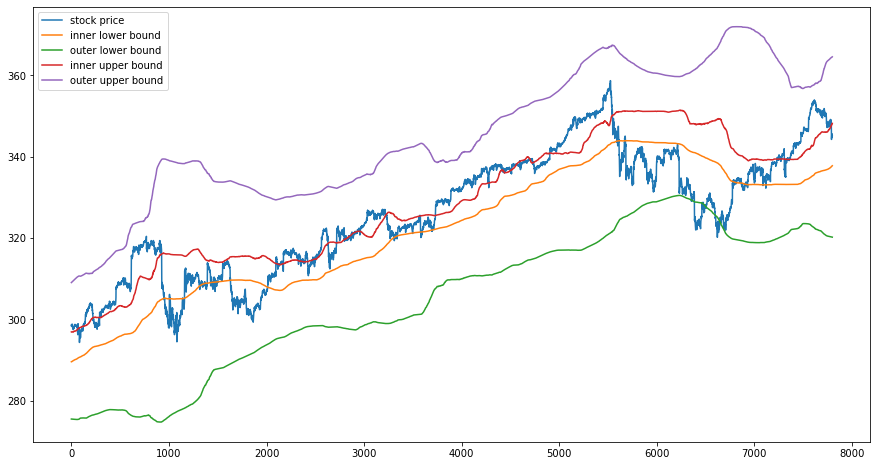

In [128]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(stock_price_history,label = 'stock price')
plt.plot(inner_lower_bound_history,label = 'inner lower bound')
plt.plot(outer_lower_bound_history,label = 'outer lower bound')
plt.plot(inner_upper_bound_history,label = 'inner upper bound')
plt.plot(outer_upper_bound_history,label = 'outer upper bound')

plt.legend()
plt.show()

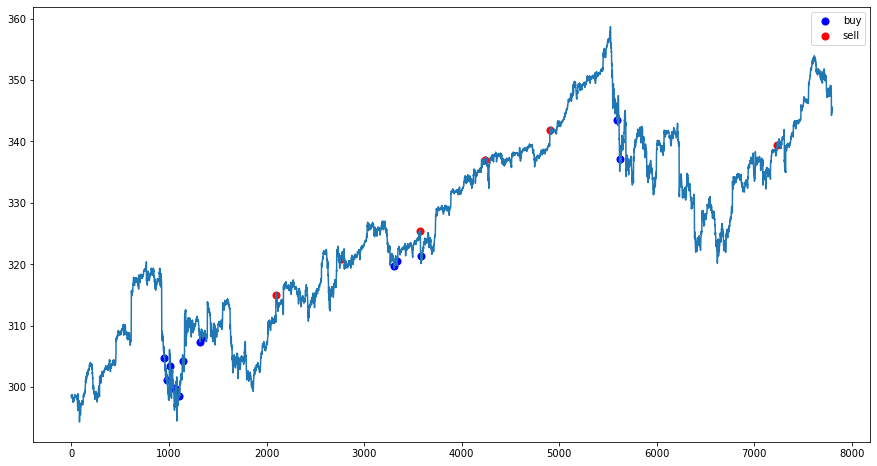

In [129]:
already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(stock_price_history)
for time_index in range(0,len(action_history[0])):

    if action_history[0,time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,stock_price_history[time_index],color = 'b',label = 'buy',s = 50)
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,stock_price_history[time_index],color = 'b',s = 50)

    elif action_history[0,time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,stock_price_history[time_index],color = 'r',label = 'sell',s = 50)
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,stock_price_history[time_index],color = 'r',s = 50)
            
plt.legend()
plt.show()

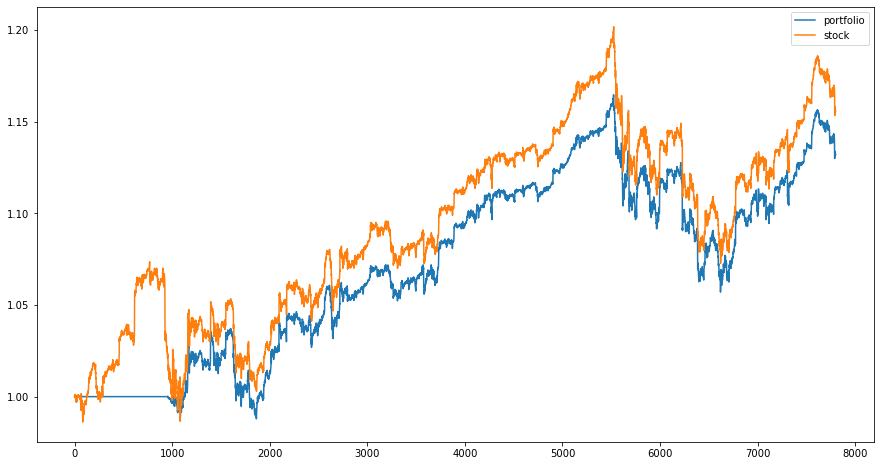

In [130]:
plt.plot(np.asarray(portfolio_value)/portfolio_value[0],label = 'portfolio')
plt.plot(np.asarray(stock_price_history)/stock_price_history[0],label = 'stock')
plt.legend()
plt.show()